In [2]:
import calim

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

import seaborn as sns
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.cluster import DBSCAN
import scipy
from statannotations.Annotator import Annotator


import sys
from pathlib import Path
module_path = str(Path.cwd().parents[1] / "custom_functs")

if module_path not in sys.path:
    sys.path.append(module_path)

from modules import customfunctions as cf


color_palette = sns.color_palette("colorblind")




#styles for error and markers in sns.lineplot

thin_custom_lw = 1.2
custom_lw = thin_custom_lw/0.65

filled_marker_style = dict(marker='o',  markersize=5,
                           color='k',
                           markerfacecolor='w',
                           markeredgecolor='k',
                          markeredgewidth=thin_custom_lw)

filled_marker_style_white = dict(marker='o',  markersize=5,
                           color='w',
                           markerfacecolor='w',
                           markeredgecolor='w',
                          markeredgewidth=custom_lw)


error_style_white = {"capsize": 4.4, 
                "ecolor": "w",
               "barsabove":False, 
               "elinewidth":custom_lw, 
               "capthick":custom_lw,
                    "zorder": 8}

error_style = {"capsize": 4, 
                "ecolor": "k",
                "barsabove":False, 
                "elinewidth":thin_custom_lw, 
                "capthick":thin_custom_lw,
                "zorder": 9}




ModuleNotFoundError: No module named 'modules'

In [5]:
module_path

'C:\\Users\\dinhha\\OneDrive - Charité - Universitätsmedizin Berlin\\Analysis\\Cacna1h KO Paper\\Skripte\\custom_functs'

In [2]:
# number of iterations and seed for bootstrapping during calculation of confidence intervals
n_boot = 10000
seed = 10

3.737
1.759
10000
10


In [3]:
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 50)

In [5]:
"""filename_KO = "..\Cacna1hKO_KO_295_Cal520.hdf"
filename_WT = "..\Cacna1hKO_WT_295_Cal520.hdf"



data_KO = calim.Project()
data_WT = calim.Project()
data_KO.from_hdf(filename_KO)
data_WT.from_hdf(filename_WT)"""

In [6]:
print("Start")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

#cutoff for burst parameters
co_WT = 3.737 
co_KO = 1.759

data = pd.DataFrame()
for file in [data_WT, data_KO]:
    print(f"Processing recordings for {file}:")
    for recording in file.recordings:
        print(recording)

        r = file.recordings[recording]
        
        # go through all cells
        for cell in r.cells:    
            # get recording information
            info = {desc: r.information[desc] for desc in r.information}

            c = r.cells[cell]


            if c.use:
                print(cell)

                # go through all conditions
                for con in r.conditions:

                    # get con infromation
                    info["recording"] = recording
                    info["start"] = int(con.start) 
                    info["cell"] = cell
                    info["dt"] = r.dt # Add "dt" aka seconds/frame                

                    info.update({desc: con.information[desc] for desc in con.information}) # Add all further condition variables           

                    start = int(con.start)
                    end = int(con.end)
                    
                    if (end-start)*r.dt > 450: #cutoff segment after 7.5 min (450 seconds)
                        end = int(start+(450/r.dt))
                    
                    end_5min = int(start + (300/r.dt)) # add 300 seconds
                    info["end"] = end
                    info["len_seg"] = (end-start)*r.dt

                    
                    
                    # calculate activity
                    info["num_events"]  = len(list(c.get_event(range(start, end)))) # Number of events
                    if info["num_events"]  == 0:
                        continue
                    else:
                        info["activity"] = (info["num_events"]/(end-start))/r.dt # Events/s
                            
                    info["num_events_5min"] = len(list(c.get_event(range(start, end_5min)))) # Number of events first 5 min
                    info["activity_5min"] = (info["num_events_5min"]/(end_5min-start))/r.dt # Events/s
                    
                    #set cutoff for burst partameters depending on genotype
                    if info["genotype"] == "wt":
                        cutoff = co_WT
                    elif info["genotype"] == "KO":
                        cutoff = co_KO
                    else:
                        print("!!!!")
                        cutoff = np.nan
                    #get burst parameters
                    list_bursts, list_ISI = cf.getBursts(list(c.get_event(list(range(start, end)))),\
                                                         dt=r.dt, maxEventLength=cutoff)
                    
                    
                   
                    #print(list_ISI)
                    if len(list_ISI) == 0:
                        info["ISI"] = np.nan
                    else:
                        info["ISI"] = list_ISI["frame"].diff().iloc[1::2].mean()*r.dt
                        
                    #print(info["ISI"] )

                    list_bursts = list_bursts.reset_index(drop=True)
                           
                    if len(list_bursts) == 0:
                        info["intraburst_freq"] = np.nan
                        info["burst_num_spikes"] = np.nan
                        info["burst_length"] = np.nan
                        info["burst_n"] = np.nan
                        info["burst_per_cell_per_sec"] = np.nan
                        
                        
                    info["intraburst_freq"], \
                    info["burst_num_spikes"], \
                    info["burst_length"], \
                    info["burst_n"], \
                    info["burst_per_cell_per_sec"] = cf.getBurstParams(list_bursts,r.dt, cutoff,start, end)
                    
                    data = pd.concat((data, pd.DataFrame.from_dict(info, orient="index").T), ignore_index=True)
                    #data = data.append(pd.Series(info), ignore_index=True)





print("Done")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

data.to_csv("data_Calbryte_activity_burstparam_230320.csv")
print("Save data to data_Calbryte_activity_burstparam_230320.csv")

Start
###### date and time ######
20-Mar-2023 19:00
Processing recordings for <calim.Project object at 0x00000283A5E09850>:
200526_s1r2_Results.csv
Mean10
Mean11
Mean12
Mean2
Mean3
Mean4
Mean5
Mean6
Mean7
Mean8
Mean9
200610_s2r1_Results.csv
Mean1
Mean10
Mean11
Mean12
Mean13
Mean14
Mean15
Mean16
Mean17
Mean18
Mean19
Mean2
Mean20
Mean21
Mean3
Mean4
Mean6
Mean7
Mean8
Mean9
200610_s3r1_Results.csv
Mean1
Mean10
Mean11
Mean12
Mean13
Mean14
Mean15
Mean16
Mean17
Mean18
Mean2
Mean4
Mean5
Mean6
Mean7
Mean8
Mean9
200610_s4r1_Results.csv
Mean1
Mean10
Mean11
Mean12
Mean13
Mean14
Mean15
Mean16
Mean17
Mean18
Mean19
Mean2
Mean20
Mean21
Mean22
Mean23
Mean24
Mean25
Mean26
Mean27
Mean28
Mean29
Mean3
Mean4
Mean5
Mean6
Mean7
Mean8
Mean9
200610_s5r1_Results.csv
Mean1
Mean10
Mean11
Mean12
Mean13
Mean14
Mean15
Mean16
Mean17
Mean18
Mean19
Mean2
Mean20
Mean21
Mean22
Mean23
Mean24
Mean25
Mean26
Mean27
Mean28
Mean29
Mean3
Mean30
Mean31
Mean32
Mean4
Mean5
Mean6
Mean7
Mean8
Mean9
200610_s6r1_Results.csv
Mean1
Mean1

# Load Data

In [3]:
cols = ["genotype", "angiotensin", "potassium","recording","dt", "animal", "sex", "cell","pos",
        "activity","activity_5min","intraburst_freq", "burst_length","burst_per_cell_per_sec","ISI","len_seg"]
data = pd.read_csv("data_Calbryte_activity_burstparam_230320.csv", usecols=cols)  
print("Load data")
now = datetime.now().strftime("%d-%b-%Y %H:%M")
print("###### date and time ######")
print(now)

Load data
###### date and time ######
26-Mar-2023 12:40


In [4]:
#filter data
data = data.groupby(["angiotensin", "potassium"]).get_group((500,4))
# remove data with low activity
data_act_corr = data[data["activity_5min"]>= 0.17]
len(data_act_corr)
# keep recording with at least 6 cells 
drop_rec = data_act_corr.groupby(["genotype", "recording"])\
            .count().reset_index().query("cell<6").recording.unique()
data_act_corr = data_act_corr[~data_act_corr.recording.isin(drop_rec)]

In [5]:
len(data_act_corr)

311

In [6]:
# annotate number of cells whithhin a recording and pos that have intraburst_freq 
data_act_corr["freq_exist"] = data_act_corr["intraburst_freq"]-data_act_corr["intraburst_freq"]+1
n_freq = data_act_corr[["recording", "pos","freq_exist"]].value_counts(dropna=False).reset_index(name='f_count')\
                    .query("freq_exist==1")[["recording", "pos", "f_count"]]
data_act_corr = pd.merge(data_act_corr, n_freq, on=["recording", "pos"])
print(len(data_act_corr))

311


In [7]:
# annotate number of cells whithhin a recording and pos that have burst lenght 
data_act_corr["burstL_exist"] = data_act_corr["burst_length"]-data_act_corr["burst_length"]+1
n_burstL = data_act_corr[["recording", "pos","burstL_exist"]].value_counts(dropna=False).reset_index(name='b_count')\
                    .query("burstL_exist==1")[["recording", "pos", "b_count"]]
data_act_corr = pd.merge(data_act_corr, n_burstL, on=["recording", "pos"])
print(len(data_act_corr))

311


In [8]:
# annotate number of cells whithhin a recording and pos that have burst lenght 
data_act_corr["isi_exist"] = data_act_corr["ISI"]-data_act_corr["ISI"]+1
n_ISI = data_act_corr[["recording", "pos","isi_exist"]].value_counts(dropna=False).reset_index(name='isi_count')\
                    .query("isi_exist==1")[["recording", "pos", "isi_count"]]
data_act_corr = pd.merge(data_act_corr, n_ISI, on=["recording", "pos"])
print(len(data_act_corr))

311


In [9]:
print(data_act_corr.groupby(["genotype"]).count().cell)
print(data_act_corr.groupby(["genotype"]).nunique().animal)
print(data_act_corr.groupby(["genotype"]).nunique().recording)

genotype
KO    103
wt    208
Name: cell, dtype: int64
genotype
KO    5
wt    7
Name: animal, dtype: int64
genotype
KO     7
wt    11
Name: recording, dtype: int64


In [10]:
df_n_animal_rec_cell = pd.concat([data_act_corr.groupby(["genotype"]).nunique().animal, 
           data_act_corr.groupby(["genotype"]).nunique().recording,
           data_act_corr.groupby(["genotype"]).count().cell],
         axis=1).reindex(['wt', 'KO'])
df_n_animal_rec_cell

,animal,recording,cell
genotype,,,
wt,7,11,208
KO,5,7,103


In [11]:
#calculate number of cells
cell_data = pd.DataFrame(data_act_corr.groupby(["genotype", "animal", "recording"]).nunique().cell)

In [12]:
#reshape data to per slice analysis
df_recs = data_act_corr[["recording", "genotype", "animal"]].drop_duplicates().set_index('recording')
df_per_slice = data_act_corr.groupby(["recording"]).mean().reset_index()
df_per_slice = df_per_slice.join(df_recs, on="recording")
df_per_slice.to_csv("df_per_slice_Calbryte_activity_burstparam_7p5_230320.csv")

<ipython-input-12-dbd3f4047a61>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_per_slice = data_act_corr.groupby(["recording"]).mean().reset_index()


In [14]:
#save data
data_act_corr.to_csv("data_filtered_Calbryte_activity_burstparam_230220.csv")
cell_data.reset_index().to_csv("data_Calbryte_cell_data_2300320.csv")

In [15]:
# load results of statistical tests
anova_activity = pd.read_csv("anova_result_activity_7p5_cal_230321.csv")["Pr(>Chisq)"][1]
anova_intraburst = pd.read_csv("anova_result_intraburst_freq_7p5_cal_230321.csv")["Pr(>Chisq)"][1]
anova_burst_length = pd.read_csv("anova_result_burst_length_7p5_cal_230321.csv")["Pr(>Chisq)"][1]
anova_ISI = pd.read_csv("anova_result_ISI_7p5_cal_230321.csv")["Pr(>Chisq)"][1]
anova_cell = pd.read_csv("anova_result_cell_7p5_cal_230321.csv")["Pr(>Chisq)"][1]


pairs = [('wt', 'KO')]

In [16]:
print(anova_activity)
print(anova_intraburst)
print(anova_burst_length)
print(anova_ISI)
print(anova_cell)

0.002624064913969
0.0125624435287031
0.242331240804879
0.013484938319645
0.370250320423663


In [17]:
print(data_act_corr.groupby(["genotype"]).mean().activity)
print(data_act_corr.query("f_count>5").groupby(["genotype"]).mean().intraburst_freq)
print(data_act_corr.query("b_count>5").groupby(["genotype"]).mean().burst_length)
print(data_act_corr.query("isi_count>5").groupby(["genotype"]).mean().ISI)

genotype
KO    1.006947
wt    0.483793
Name: activity, dtype: float64
genotype
KO    1.317785
wt    0.881153
Name: intraburst_freq, dtype: float64
genotype
KO    70.775561
wt    81.293040
Name: burst_length, dtype: float64
genotype
KO    41.632976
wt    63.530516
Name: ISI, dtype: float64


<ipython-input-17-2d771cd7295e>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data_act_corr.groupby(["genotype"]).mean().activity)
<ipython-input-17-2d771cd7295e>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data_act_corr.query("f_count>5").groupby(["genotype"]).mean().intraburst_freq)
<ipython-input-17-2d771cd7295e>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(data_act_corr.query("b_count

In [14]:
#calculate ci 95% - version 1 
var = ["activity", "intraburst_freq","ISI","burst_length"]
genotypes = df_per_slice["genotype"].unique()
ci_df = pd.DataFrame()

for v in var:
    ci_lower = pd.Series(dtype="float64", name=f"{v}_ci95_lower")
    ci_upper = pd.Series(dtype="float64", name=f"{v}_ci95_upper")
    for g in genotypes:
        vals = df_per_slice[(df_per_slice["genotype"]==g)][v].values
        vals = [item for item in vals if not(pd.isna(item)) == True]
        res = scipy.stats.bootstrap((vals,),
                                    np.mean,
                                    confidence_level=0.95,
                                    n_resamples=int(n_boot),
                                    random_state=int(seed),
                                   method="percentile")
        #print(res.confidence_interval)
        ci_l, ci_u = res.confidence_interval
        ci_lower = pd.concat((ci_lower,pd.Series(data=ci_l, index=[g], name=f"{v}_ci95_lower")))
        ci_upper = pd.concat((ci_upper,pd.Series(data=ci_u, index=[g], name=f"{v}_ci95_upper")))
        #print("-----------")
        #print(v)
        #print(g)
        #print(ci_lower)
        #print(ci_upper)
    ci_df = pd.concat((ci_df,df_per_slice.groupby(["genotype"]).mean()[v]), axis=1)
    ci_df = pd.concat((ci_df,ci_lower), axis=1)
    ci_df = pd.concat((ci_df,ci_upper), axis=1) 

<ipython-input-14-526d59e82fe1>:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ci_df = pd.concat((ci_df,df_per_slice.groupby(["genotype"]).mean()[v]), axis=1)
<ipython-input-14-526d59e82fe1>:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ci_df = pd.concat((ci_df,df_per_slice.groupby(["genotype"]).mean()[v]), axis=1)
<ipython-input-14-526d59e82fe1>:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ci_df = pd.conc

In [16]:
#calculate ci 95% - version 2
var = ["activity", "intraburst_freq","ISI","burst_length"]
genotypes = df_per_slice["genotype"].unique()
ci_df_2 = pd.DataFrame()

for v in var:
    ci_lower = pd.Series(dtype="float64", name=f"{v}_ci95_lower")
    ci_upper = pd.Series(dtype="float64", name=f"{v}_ci95_upper")
    for g in genotypes:
        vals = df_per_slice[(df_per_slice["genotype"]==g)][v].values
        vals = [item for item in vals if not(pd.isna(item)) == True]
        res = scipy.stats.bootstrap((vals,),
                                    np.mean,
                                    confidence_level=0.95,
                                    n_resamples=int(n_boot),
                                    random_state=int(seed),
                                   method="percentile")
        #print(res.confidence_interval)
        ci_l, ci_u = res.confidence_interval
        ci_lower = pd.concat((ci_lower,pd.Series(data=ci_l, index=[g], name=f"ci95_lower")))
        ci_upper = pd.concat((ci_upper,pd.Series(data=ci_u, index=[g], name=f"ci95_upper")))
        #print("-----------")
        #print(v)
        #print(g)
        #print(ci_lower)
        #print(ci_upper)
        
    ci_lower.name = "ci_lower"
    ci_upper.name = "ci_upper"
    ci_temp = pd.concat((ci_lower,ci_upper), axis=1)
    ci_temp.index.name="genotype"
    ci_temp["parameter"] = v
    ci_temp.set_index('parameter', append=True, inplace=True)
        
    df_var = df_per_slice.groupby(["genotype"]).mean()[v]
    arr = [df_var.index.values, [df_var.name, df_var.name]]
    tuples = list(zip(*arr))
    multi_idx = pd.MultiIndex.from_tuples(tuples, names=["genotype", "parameter"])
        
    df_var.index = multi_idx
    
    df_var.name = "mean"

    df_temp = pd.concat((df_var, ci_temp), axis=1)
    ci_df_2 = pd.concat((ci_df_2,df_temp), axis=0)
ci_df_2 = ci_df_2.reindex(["wt", "KO"], level="genotype")

<ipython-input-16-c659445a7a3d>:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df_per_slice.groupby(["genotype"]).mean()[v]
<ipython-input-16-c659445a7a3d>:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df_per_slice.groupby(["genotype"]).mean()[v]
<ipython-input-16-c659445a7a3d>:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_var = df_per_slice.groupby(["genotype"]).mean()[v]
<ipython-inpu

In [17]:
#save table with mean and ci 95%
df_summary = pd.concat([df_n_animal_rec_cell,
                        ci_df.reindex(['wt', 'KO'])],
                       axis=1).T
#df_summary.to_csv("data_summary_activity_burstparam_7p5_per_slice_230305.csv")
#df_summary.to_excel("data_summary_activity_burstparam_7p5_per_slice_230305.xlsx")

ci_df_2.to_csv("data_summary_activity_burstparam_v2_7p5_per_slice_230305.csv")
ci_df_2.to_excel("data_summary_activity_burstparam_v2_7p5_per_slice_230305.xlsx")

<ipython-input-17-3e7c839da5c2>:9: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  ci_df_2.to_excel("data_summary_activity_burstparam_v2_7p5_per_slice_230305.xlsx")


In [56]:
"""doc = docx.Document()

df_n_animal_rec_cell_2 = df_n_animal_rec_cell.reset_index()\
                        .rename(columns={"genotype": "Genotype",
                             "animal": "Animal",
                             "recording": "Recording",
                             "cell": "Cell",
                            })

ci_df_3 = ci_df_2.round(decimals=3)\
            .reset_index()\
            .rename(columns={"genotype": "Genotype",
                             "parameter": "Parameter",
                             "mean": "Mean",
                             "ci_lower": "95% CI\n(lower limit)",
                             "ci_upper": "95% CI\n(upper limit)",

                            })\
            .replace(to_replace=["activity", 
                            "intraburst_freq",
                            "burst_length", 
                            "burst_per_cell_per_sec",
                            "ISI",
                            "wt"
                           ], 
                value=["Activity (spikes/s)", 
                       "Intra-burst frequency (1/s)",
                       "Burst length (1/s)",
                       "Number of bursts (1/cell/s)",
                       "Inter-burst interval (s)",
                       "WT"
                      ])

for df in [df_n_animal_rec_cell_2, ci_df_3]:

    # add a table to the end and create a reference variable
    # extra row is so we can add the header row
    t = doc.add_table(df.shape[0]+1, df.shape[1])
    t.style = 'Light Grid'


    # add the header rows.
    for j in range(df.shape[-1]):
        t.cell(0,j).text = df.columns[j]

    # add the rest of the data frame
    for i in range(df.shape[0]):
        for j in range(df.shape[-1]):
            t.cell(i+1,j).text = str(df.values[i,j])


    # change font style  
    for row in t.rows:
        for cell in row.cells:
            paragraphs = cell.paragraphs
            for paragraph in paragraphs:
                for run in paragraph.runs:
                    font = run.font
                    font.size= Pt(11)
                    font.name = 'Arial'
    doc.add_page_break()

  
        
# save the doc
doc.save('test.docx')"""

'doc = docx.Document()\n\ndf_n_animal_rec_cell_2 = df_n_animal_rec_cell.reset_index()                        .rename(columns={"genotype": "Genotype",\n                             "animal": "Animal",\n                             "recording": "Recording",\n                             "cell": "Cell",\n                            })\n\nci_df_3 = ci_df_2.round(decimals=3)            .reset_index()            .rename(columns={"genotype": "Genotype",\n                             "parameter": "Parameter",\n                             "mean": "Mean",\n                             "ci_lower": "95% CI\n(lower limit)",\n                             "ci_upper": "95% CI\n(upper limit)",\n\n                            })            .replace(to_replace=["activity", \n                            "intraburst_freq",\n                            "burst_length", \n                            "burst_per_cell_per_sec",\n                            "ISI",\n                            "wt"\n              

# $\Downarrow$ Activity  $\Downarrow$

<ipython-input-24-feaff79b4347>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "KO"])
C:\Users\hoang\anaconda3\lib\site-packages\statannotations\Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wt vs. KO: Custom statistical test, P_val:2.624e-03
{'alpha': 0.05, 'color': '0.2', 'comparisons_correction': None, 'line_height': 0.05, 'line_offset': None, 'line_offset_to_group': 0.06, 'line_width': 1.5, 'loc': 'inside', 'pvalue_format': {'correction_format': '{star} ({suffix})', 'fontsize': '10', 'pvalue_format_string': '{:.3e}', 'simple_format_string': '{:.2f}', 'text_format': 'star', 'pvalue_thresholds': [[0.0001, '****'], [0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']], 'show_test_name': True}, 'show_test_name': False, 'test': None, 'test_short_name': '', 'text_offset': -2, 'use_fixed_offset': True, 'verbose': True}


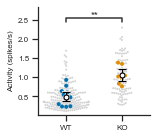

In [24]:
y = "activity"
data = df_per_slice.dropna(subset=[y])
pval = anova_activity


fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, 
                  order=["wt", "KO"],
               hue="genotype", 
                  palette=(color_palette[1], color_palette[0]),
               s=4, zorder=2)

sns.swarmplot(x="genotype", y=y, data=data_act_corr.dropna(subset=[y]), 
                  order=["wt", "KO"],
               hue="genotype", palette=("lightgrey", "lightgrey"),
               s=2, zorder=1)


sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)
#plt.ylim(0, 2.5)
plt.xlim(-0.5, 1.5)

g.set_xticklabels(["WT", "KO"])
g.set_ylabel("Activity (spikes/s)")
g.set_xlabel("")

plt.legend([],[], frameon=False)

annotator = Annotator(g, pairs, data=data, x="genotype", y=y, order=["wt", "KO"])
annotator.set_custom_annotations([f'p={anova_activity:.2e}'])
annotator.set_pvalues([pval])
annotator.configure(fontsize="10", line_height=0.05, text_offset=-2, loc="inside", use_fixed_offset=True)
annotator.annotate()
print(annotator.get_configuration())

sns.despine()
plt.savefig("plots/activity_7p5_per_slice.svg", bbox_inches="tight")
plt.savefig("plots/activity_7p5_per_slice.png", dpi=300, bbox_inches="tight")
plt.show()

<ipython-input-25-db8a856ac2cd>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "KO"])
C:\Users\hoang\anaconda3\lib\site-packages\statannotations\Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wt vs. KO: Custom statistical test, P_val:2.624e-03
{'alpha': 0.05, 'color': '0.2', 'comparisons_correction': None, 'line_height': 0.05, 'line_offset': None, 'line_offset_to_group': 0.06, 'line_width': 1.5, 'loc': 'inside', 'pvalue_format': {'correction_format': '{star} ({suffix})', 'fontsize': '10', 'pvalue_format_string': '{:.3e}', 'simple_format_string': '{:.2f}', 'text_format': 'star', 'pvalue_thresholds': [[0.0001, '****'], [0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']], 'show_test_name': True}, 'show_test_name': False, 'test': None, 'test_short_name': '', 'text_offset': -2, 'use_fixed_offset': True, 'verbose': True}


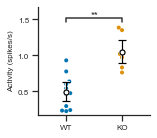

In [25]:
y = "activity"
data = df_per_slice.dropna(subset=[y])
pval = anova_activity


fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, 
                  order=["wt", "KO"],
               hue="genotype", palette=(color_palette[1], color_palette[0]),
               s=4, zorder=1)


sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)
#plt.ylim(0, 2.5)
plt.xlim(-0.5, 1.5)

g.set_xticklabels(["WT", "KO"])
g.set_ylabel("Activity (spikes/s)")
g.set_xlabel("")

plt.legend([],[], frameon=False)

annotator = Annotator(g, pairs, data=data, x="genotype", y=y, order=["wt", "KO"])
annotator.set_custom_annotations([f'p={anova_activity:.2e}'])
annotator.set_pvalues([pval])
annotator.configure(fontsize="10", line_height=0.05, text_offset=-2, loc="inside", use_fixed_offset=True)
annotator.annotate()
print(annotator.get_configuration())

sns.despine()
plt.savefig("plots/activity_7p5_per_slice_v2.svg", bbox_inches="tight")
plt.savefig("plots/activity_7p5_per_slice_v2.png", dpi=300, bbox_inches="tight")
plt.show()

# $\Downarrow$ Burst Parameter  $\Downarrow$

$\Downarrow$ intraburst freq   $\Downarrow$

<ipython-input-38-0cd0e90f209e>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "KO"])
C:\Users\hoang\anaconda3\lib\site-packages\statannotations\Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wt vs. KO: Custom statistical test, P_val:1.256e-02
{'alpha': 0.05, 'color': '0.2', 'comparisons_correction': None, 'line_height': 0.05, 'line_offset': None, 'line_offset_to_group': 0.06, 'line_width': 1.5, 'loc': 'inside', 'pvalue_format': {'correction_format': '{star} ({suffix})', 'fontsize': '10', 'pvalue_format_string': '{:.3e}', 'simple_format_string': '{:.2f}', 'text_format': 'star', 'pvalue_thresholds': [[0.0001, '****'], [0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']], 'show_test_name': True}, 'show_test_name': True, 'test': None, 'test_short_name': '', 'text_offset': -2, 'use_fixed_offset': True, 'verbose': True}


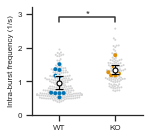

In [38]:
y = "intraburst_freq"
data = df_per_slice.dropna(subset=[y]).query("f_count>5")
pval = anova_intraburst

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, order=["wt","KO"],hue_order=["wt","KO"],
                hue="genotype", palette=(color_palette[0], color_palette[1]),
              s=4, zorder=2)

sns.swarmplot(x="genotype", y=y, data=data_act_corr.dropna(subset=[y]), 
                     order=["wt","KO"], hue_order=["wt","KO"],
              hue="genotype", palette=("lightgrey", "lightgrey"),
               s=2, zorder=1)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

plt.ylim(0, 3.2)
plt.xlim(-0.5, 1.5)

g.set_xticklabels(["WT", "KO"])
g.set_ylabel("Intra-burst frequency (1/s)")
g.set_xlabel("")
plt.legend([],[], frameon=False)

annotator = Annotator(g, pairs, data=data, x="genotype", y=y, order=["wt", "KO"])
#annotator.set_custom_annotations([f'p={anova_activity:.2e}'])
annotator.set_pvalues([pval])
annotator.configure(fontsize="10", line_height=0.05, text_offset=-2, loc="inside", use_fixed_offset=True)
annotator.annotate()
print(annotator.get_configuration())

sns.despine()
plt.savefig("plots/intra_burst_7p5_freq_per_slice.svg", bbox_inches="tight")
plt.savefig("plots/intra_burst_7p5_freq_per_slice.png", dpi=300, bbox_inches="tight")
plt.show()

$\Downarrow$ Burst length   $\Downarrow$

<ipython-input-23-fed9d6c9977d>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "KO"])
C:\Users\hoang\anaconda3\lib\site-packages\statannotations\Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wt vs. KO: Custom statistical test, P_val:2.423e-01


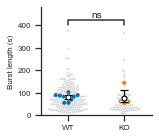

In [23]:
y = "burst_length"
data = df_per_slice.dropna(subset=[y]).query("b_count>5")
pval = anova_burst_length

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, order=["wt","KO"],hue_order=["wt","KO"],
                hue="genotype", palette=(color_palette[0], color_palette[1]),
              s=4, zorder=2)

sns.swarmplot(x="genotype", y=y, data=data_act_corr.dropna(subset=[y]), 
                  order=["wt", "KO"], hue_order=["wt","KO"],
               hue="genotype", palette=("lightgrey", "lightgrey"),
               s=2, zorder=1)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

plt.ylim(0, 440)
plt.xlim(-0.5, 1.5)




g.set_xticklabels(["WT", "KO"])
g.set_ylabel("Burst length (s)")
g.set_xlabel("")
plt.legend([],[], frameon=False)

annotator = Annotator(g, pairs, data=data, x="genotype", y=y, order=["wt", "KO"])
#annotator.set_custom_annotations([f'p={anova_activity:.2e}'])
annotator.set_pvalues([pval])
annotator.configure(fontsize="10", line_height=0.05, text_offset=0, loc="inside", use_fixed_offset=True)
annotator.annotate()
#print(annotator.get_configuration())


sns.despine()
plt.savefig("plots/burst_length_7p5_swarm_paper.svg", bbox_inches="tight")
plt.savefig("plots/burst_length_7p5_swarm_paper.png", dpi=300, bbox_inches="tight")
plt.show()

$\Downarrow$ Inter-burst interval  $\Downarrow$

<ipython-input-26-5cde1b06812d>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "KO"])
C:\Users\hoang\anaconda3\lib\site-packages\statannotations\Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wt vs. KO: Custom statistical test, P_val:1.348e-02


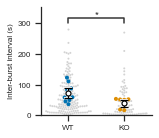

In [26]:
y = "ISI"
data = df_per_slice.dropna(subset=[y]).query("isi_count>5")
pval = anova_ISI

fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(x="genotype", y=y, data=data, order=["wt","KO"],hue_order=["wt","KO"],
                hue="genotype", palette=(color_palette[0], color_palette[1]),
              s=4, zorder=2)

sns.swarmplot(x="genotype", y=y, data=data_act_corr.dropna(subset=[y]), 
                    order=["wt","KO"],hue_order=["wt","KO"],
              hue="genotype", palette=("lightgrey", "lightgrey"),
               s=2, zorder=1)


sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y=y, data=data, lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)
plt.xlim(-0.5, 1.5)
plt.ylim(0, 350)


g.set_xticklabels(["WT", "KO"])

g.set_ylabel("Inter-burst interval (s)")
g.set_xlabel("")
plt.legend([],[], frameon=False)

annotator = Annotator(g, pairs, data=data, x="genotype", y=y, order=["wt", "KO"])
#annotator.set_custom_annotations([f'p={anova_activity:.2e}'])
annotator.set_pvalues([pval])
annotator.configure(fontsize="10", line_height=0.05, text_offset=-2, loc="inside")
annotator.annotate()
#print(annotator.get_configuration())

sns.despine()
plt.savefig("plots/ISI_7p5_swarm_paper.svg", bbox_inches="tight")
plt.savefig("plots/ISI_7p5_swarm_paper.png", dpi=300, bbox_inches="tight")
plt.show()

# numbers of cells $\Downarrow$

In [31]:
cell_data.reset_index().groupby("genotype").get_group(("wt"))["cell"].mean()

18.90909090909091

In [32]:
cell_data.reset_index().groupby("genotype").get_group(("KO"))["cell"].mean()

14.714285714285714

In [33]:
cell_data.reset_index().groupby("genotype").get_group(("wt"))["cell"].sem()

3.543122776346378

In [34]:
cell_data.reset_index().groupby("genotype").get_group(("KO"))["cell"].sem()

2.5327783137089908

<ipython-input-35-9c266097e6f8>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(["WT", "KO"])
C:\Users\hoang\anaconda3\lib\site-packages\statannotations\Annotator.py:805: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

wt vs. KO: Custom statistical test, P_val:3.703e-01


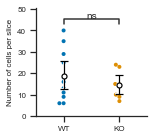

In [35]:
fig, g = plt.subplots(figsize=(2, 2))
pval = anova_cell



g =  sns.swarmplot(x="genotype", y="cell", data=cell_data.reset_index(),  order=["wt", "KO"],
                 hue="genotype", palette=(color_palette[1], color_palette[0]),
                 s=4, zorder=1, legend=False)

sns.lineplot(x="genotype", y="cell", data=cell_data.reset_index().sort_values(by=['genotype'], ascending=False),
             lw=0, sort=False,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)

sns.lineplot(x="genotype", y="cell", data=cell_data.reset_index(), lw=0, 
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

plt.ylim(-0.1, 50)
plt.xlim(-0.5, 1.5)


g.set_ylabel("Number of cells per slice")
g.set_xlabel("") 
g.set_xticklabels(["WT", "KO"])


annotator = Annotator(g, pairs, data=data, x="genotype", y=y, order=["wt", "KO"])
#annotator.set_custom_annotations([f'p={anova_activity:.2e}'])
annotator.set_pvalues([pval])
annotator.configure(fontsize="10", line_height=0.05, text_offset=-2, loc="inside")
annotator.annotate()
#print(annotator.get_configuration())


sns.despine()
plt.savefig("plots/number_of_cells_per_slice_7p5.svg", bbox_inches="tight")
plt.savefig("plots/number_of_cells_per_slice_7p5.png", dpi=300, bbox_inches="tight")
plt.show()